# SPECFEM Users Workshop -- Day 1 (Oct. 5, 2022)

## Part 1B: Forward Simulations

- Builds upon material learned in Day 1A  
- Day 1B notebook allows Users to play around with their own SPECFEM2D homogeneous halfspace example
- **Objective:** Familiarize Users with setting `SOURCE` and `STATION` attributes, adjusting velocity model parameters, and assess simulation results.
- These instructions should be run from inside the Docker container, using Jupyter Lab (see *Docker Preamble* in Day 0). 

-----------

**Relevant Links:** 
- Day 1 Slides !!! ADD THIS !!!
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_1b_forward_simulations.ipynb
- Completed Notebook https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb)
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_0_container_testing.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)


## 1) Setting Up a SPECFEM Working Directory

- It is often desireable to run SPECFEM outside of the cloned repository, in order to keep files and outputs manageable. 
- The trick here is that SPECFEM only requires 3 compenents for a sucessful simulation, the `bin/`, `DATA/`, and `OUTPUT_FILES/` directories. 
- Here we will set up a SPECFEM2D working directory that we can play around with.
- **NOTE:** We will working in the directory `/home/scoped/work/day_1/specfem2d_workdir`. All the following cells assume that we are in this directory, so you must evaluate the '%cd' command to ensure that cells work as expected.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
# Make correct dir. and move there
! mkdir -p /home/scoped/work/day_1/specfem2d_workdir
%cd /home/scoped/work/day_1/specfem2d_workdir

# Symlink the binary files, and copy the relevant DATA/ directory
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

! ls

/home/scoped/work/day_1/specfem2d_workdir
bin  DATA  OUTPUT_FILES


## 2) Experimental Setup: Tape et al. 2007 Example Problem

- We will be working with an Example problem from the Tape et al. 2007 GJI publication: https://academic.oup.com/gji/article/168/3/1105/929373
- Location of the example problem *(only for viewing pleasure)*: https://github.com/geodynamics/specfem2d/tree/devel/EXAMPLES/Tape2007
- This example pre-defines a starting model, target model, seismic sources and station locations. 
- For now we will just be working with the starting model, a homogeneous halfspace.
- We will be using Python (NumPy and Matplotlib) to visualize the Example problem setup, however in your own research you can use any language to help you visualize and understand your problem.

In [4]:
! ls DATA/

interfaces_Tape2007.dat		  SOURCE_005  SOURCE_013  SOURCE_021
model_velocity.dat_checker	  SOURCE_006  SOURCE_014  SOURCE_022
Par_file_Tape2007_132rec_checker  SOURCE_007  SOURCE_015  SOURCE_023
Par_file_Tape2007_onerec	  SOURCE_008  SOURCE_016  SOURCE_024
SOURCE_001			  SOURCE_009  SOURCE_017  SOURCE_025
SOURCE_002			  SOURCE_010  SOURCE_018  STATIONS_checker
SOURCE_003			  SOURCE_011  SOURCE_019
SOURCE_004			  SOURCE_012  SOURCE_020


The above example problem defines:
- `Par_file` for a starting, homogeneous halfspace model in `Par_file_Tape2007_onerec`
- `Par_file` for a target, checkerboard model in `Par_file_Tape2007_132rec_checker`
- `Mesh` files in: *interfaces_Tape2007.dat* and the `Par_file_*`
- `Model` files in: *model_velocity.dat_checker*
- `Source` files in: the 25 *SOURCE_???* files
- `Stations`: in the *STATIONS_checker* file

### a) The Homogeneous Halfspace Model

- The homogeneous halfspace model in this example is defined in the `Par_file`
- We can use the `seisflows sempar velocity_model` command to look at its values.

In [5]:
# Look at the homogeneous halfspace model
! seisflows sempar -P DATA/Par_file_Tape2007_onerec velocity_model

VELOCITY_MODEL:

1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


According to the `Par_file` comments, the model parameter values represent the following:  

```bash
model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0
1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0
```

- The homogeneous halfspace model defines a region with P-wave velocity $V_p=5.8$km/s and S-wave velocity $V_s=3.5$km/s.
- We can understand the structure of the mesh by looking at the `Par_file` and the `interfaces_Tape2007.dat` file. 
- The `Par_file` defines the X dimension of the mesh

In [6]:
# Look at Mesh parameters
! head -305 DATA/Par_file_Tape2007_onerec | tail -n 25

#-----------------------------------------------------------
#
# PARAMETERS FOR INTERNAL MESHING
#
#-----------------------------------------------------------

# file containing interfaces for internal mesh
interfacesfile                  = interfaces_Tape2007.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 480000.d0      # abscissa of right side of the model
nx                              = 40             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                       = .true.
absorbleft                      = .true.

# define the different regions of the model in the (nx,nz) spectral-element mesh
nbregions                       = 1              # then set below the different regions and 

In [7]:
# Look at interface parameters
! cat DATA/interfaces_Tape2007.dat

# number of interfaces
 2
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0.0 0.0
 480000.0 0.0
# interface number 5 (topography, top of the mesh)
 2
 0.0 480000.0
 480000.0 480000.0
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1
 40


#### Understanding the Mesh parameters

- From the files above, we can see that the X dimension of our mesh ranges 0m to 480000.0m
- The Z dimension of our mesh also ranges 0m to 480000.0m. 
- Each dimension is separated into 40 elements (defined by `nxmin`, `nxmax` etc. in the `Par_file` and defined by the layer numbers in the interfaces file)  
- That means each spectral element in our 2D mesh spans 12000.0m. \
- Also note that above we determined that the $V_s$ model has a homogeneous value of 3.5 km/s

We can make a simple plot using Matplotlib to illustrate what our mesh might look like

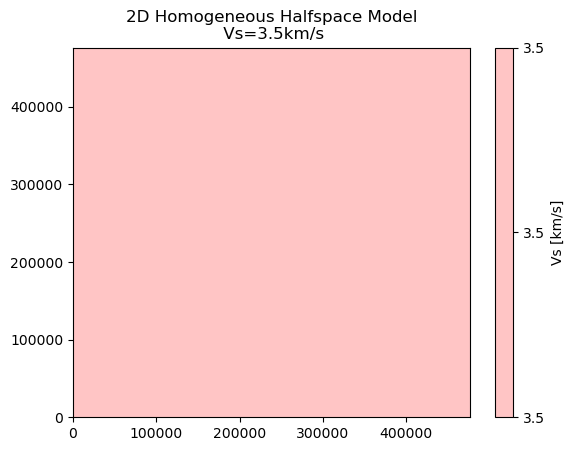

In [9]:
# Visualizing the homogeneous halfspace model
def plot_homogeneous_halfspace():
    """Plots a representation of the SPECFEM2D homogeneous halfspace model"""
    # Sets the X and Z dimensions of our mesh
    x = np.arange(0, 480000, 4000)
    z = np.arange(0, 480000, 4000)
    
    # Reformat the 1D arrays into 2D
    xv, zv = np.meshgrid(x, z)

    # Set a homogeneous value of Vs=3.5km/s 
    vs = 3.5 * np.ones(np.shape(xv))

    # Plot the arrays as a homogeneous halfspace
    plt.tricontourf(xv.flatten(), zv.flatten(), vs.flatten(), cmap="seismic_r", vmin=3.1, vmax=4.)
    plt.colorbar(label="Vs [km/s]", format="%.1f")
    plt.title("2D Homogeneous Halfspace Model\n Vs=3.5km/s")
    
# Calls the function we just defined
plot_homogeneous_halfspace()

### b) Visualizing Source-Receiver Geometry

- We can similarly plot the SOURCES and STATIONS available to see what the experiemental setup looks like.
- We can use Python to grab Cartesian coordinate values from these files. 
- Same approach we took in Day 1A notebook

In [10]:
# Grab coordinates from STATIONS file
sta_x, sta_z = np.genfromtxt("DATA/STATIONS_checker", dtype=float, usecols=[2, 3]).T

In [11]:
# Grab coordinates from each SOURCE file
ev_x, ev_z = [], []
for i in range(1, 26):
    source_file = f"DATA/SOURCE_{i:0>3}"
    with open(source_file, "r") as f:
        lines = f.readlines()
    # Trying to break apart the following line
    # 'xs = 299367.72      # source location x in meters\n'
    xs = float(lines[2].split("=")[1].split("#")[0].strip())
    zs = float(lines[3].split("=")[1].split("#")[0].strip())
    
    ev_x.append(xs)
    ev_z.append(zs)

Text(0.5, 1.0, 'SOURCE-RECEIVER GEOMETRY')

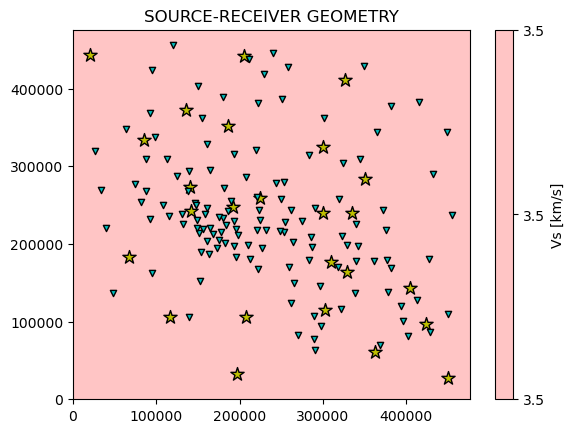

In [12]:
# Plot SOURCES and STATIONS together. Annotate names
plot_homogeneous_halfspace()
plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
plt.scatter(sta_x, sta_z, c="c", marker="v", s=20, edgecolor="k")
plt.title("SOURCE-RECEIVER GEOMETRY")

Text(0.5, 1.0, 'SOURCES')

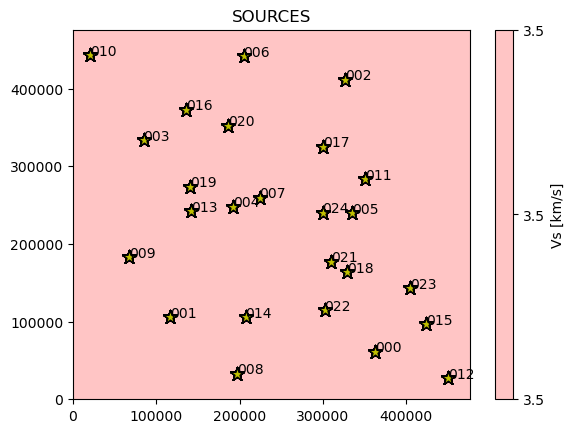

In [13]:
# Plot SOURCES next to source names
plot_homogeneous_halfspace()
for i, (x, z) in enumerate(zip(ev_x, ev_z)):
    plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
    plt.text(x, z, f"{i:0>3}")
plt.title("SOURCES")

Text(0.5, 1.0, 'STATIONS')

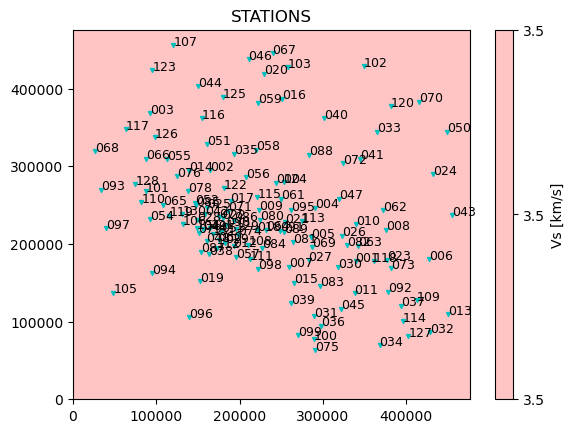

In [14]:
# Plot STATIONS with their names
# Because STATIONS are so close, numbers will be jumbled.
plot_homogeneous_halfspace()
for i, (x, z) in enumerate(zip(sta_x, sta_z)):
    plt.scatter(x, z, c="c", marker="v", s=8)
    plt.text(x, z, f"{i:0>3}", fontsize=9)
plt.title("STATIONS")

- In the above figures, the upside-down blue triangles represent the 132 receivers in this example
- The 25 yellow stars are the sources. 
- Now that we are familiar with our experimental setup, we can run SPECFEM2D to generate synthetics.

## 2) Running SPECFEM2D

- To run the example, we'll have to do a some setup of our working directory to get files in the correct place. 
- We will choose ONE of our source files to act as our source
- We will choose N stations to act as our stations

### a) Choose a Source file

- SPECFEM2D will look for a file named `SOURCE` in the *DATA/* directory. 
- There are 25 sources to choose from. You can have a look at the SOURCE plot we created in the previous section to choose which SOURCE you'd like to run. 
- By default the cell below chooses `SOURCE_001` as the main source.

In [15]:
# > CHOOSE your source file here by replacing 'SOURCE_001'
! cp -f DATA/SOURCE_001 DATA/SOURCE
# > Make sure that the SOURCE name printed below matches choice
! head -1 DATA/SOURCE

## Source 1


### b) Choosing Stations

- The `STATIONS` file defines 132 different station locations, visualized earlier. 
- We can choose what stations we use by copying over a subset of the original station list.
- By default the example chooses to use **all** 132 stations. 
- **NOTE**: Individual synthetic seismograms simply extract the simulated wavefield at a location, i.e., computational expense is not tied to the number of stations. 

In [16]:
# Write out a NEW stations file by choosing station numbers
# Change the range, or write your own list to choose station values
# e.g., STATION_CHOICE = [0, 1, 2, 3]

STATION_NUMBER_CHOICE = range(0, 132)  # <- free to select station numbers here

# Read the existing stations file
stations = open("DATA/STATIONS_checker", "r").readlines()

# Write out only User defined stations
with open("DATA/STATIONS", "w") as f:
    for i in STATION_NUMBER_CHOICE:
        f.write(stations[i])

In [17]:
! tail DATA/STATIONS

S000122 AA 1.80768e+05 2.71967e+05 0.0 0.0
S000123 AA 9.51190e+04 4.23927e+05 0.0 0.0
S000124 AA 2.53155e+05 2.79988e+05 0.0 0.0
S000125 AA 1.80081e+05 3.88769e+05 0.0 0.0
S000126 AA 9.85810e+04 3.37251e+05 0.0 0.0
S000127 AA 4.02208e+05 8.09090e+04 0.0 0.0
S000128 AA 7.46710e+04 2.76764e+05 0.0 0.0
S000129 AA 1.95613e+05 2.19240e+05 0.0 0.0
S000130 AA 1.31351e+05 2.38047e+05 0.0 0.0
S000131 AA 1.67457e+05 2.12801e+05 0.0 0.0


### c) Setting up the `Par_file`

- Need to change a few key parameters in the `Par_file` to run SPECFEM2D with desired behavior.  
- We'll explain each of the parameter changes below, and use the `seisflows sempar` command to make the changes.
- Optionally, you are welcome to open the `Par_file` directly (by double clicking) and editing parameters yourself. Be sure to check your spelling!

In [18]:
# Copy in the Example parameter file
! cp -f DATA/Par_file_Tape2007_onerec DATA/Par_file

# Set some necessary parameters for later in the Par_file
! seisflows sempar -P DATA/Par_file nproc 4
! seisflows sempar -P DATA/Par_file use_existing_stations .true.
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1

NPROC: 1 -> 4
use_existing_STATIONS: .false. -> .true.
SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1


#### Par_file parameter changes

`NPROC`: Sets the number of MPI processors to partition the mesh and run the simulation with. This MUST match the value following `-n` in the MPI call below.    
`use_existing_STATIONS`: Use the STATIONS file we created, as opposed to the `Par_file` definition of stations  
`setup_with_binary_database`: Writes database files in binary format      
`SAVE_MODEL`: Write model files in binary (.bin) format  

### d) Run the example

- Now that we have set the `Par_file`, the `SOURCE` and `STATIONS` file, we are able to run `xmeshfem2D` and `xspecfem2D` to run our forward simulation.
- Using 4 MPI processes to run this homogeneous halfspace simulation

In [19]:
# Ensures we're running with a clean OUTPUT directory
! rm -rf OUTPUT_FILES
! mkdir OUTPUT_FILES

! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem.txt
! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

### e) Examine Output Files

- Since we spent time in Day 1A looking at output results, we will skip through quickly


In [20]:
! ls OUTPUT_FILES/

AA.S000000.BXY.semd  AA.S000091.BXY.semd
AA.S000001.BXY.semd  AA.S000092.BXY.semd
AA.S000002.BXY.semd  AA.S000093.BXY.semd
AA.S000003.BXY.semd  AA.S000094.BXY.semd
AA.S000004.BXY.semd  AA.S000095.BXY.semd
AA.S000005.BXY.semd  AA.S000096.BXY.semd
AA.S000006.BXY.semd  AA.S000097.BXY.semd
AA.S000007.BXY.semd  AA.S000098.BXY.semd
AA.S000008.BXY.semd  AA.S000099.BXY.semd
AA.S000009.BXY.semd  AA.S000100.BXY.semd
AA.S000010.BXY.semd  AA.S000101.BXY.semd
AA.S000011.BXY.semd  AA.S000102.BXY.semd
AA.S000012.BXY.semd  AA.S000103.BXY.semd
AA.S000013.BXY.semd  AA.S000104.BXY.semd
AA.S000014.BXY.semd  AA.S000105.BXY.semd
AA.S000015.BXY.semd  AA.S000106.BXY.semd
AA.S000016.BXY.semd  AA.S000107.BXY.semd
AA.S000017.BXY.semd  AA.S000108.BXY.semd
AA.S000018.BXY.semd  AA.S000109.BXY.semd
AA.S000019.BXY.semd  AA.S000110.BXY.semd
AA.S000020.BXY.semd  AA.S000111.BXY.semd
AA.S000021.BXY.semd  AA.S000112.BXY.semd
AA.S000022.BXY.semd  AA.S000113.BXY.semd
AA.S000023.BXY.semd  AA.S000114.BXY.semd
AA.S000024.BXY.s

[2022-09-17 00:27:07] - pysep - INFO: starting record section plotter
[2022-09-17 00:27:07] - pysep - INFO: Reading 132 synthetics from: OUTPUT_FILES/
[2022-09-17 00:27:08] - pysep - INFO: checking parameter acceptability
[2022-09-17 00:27:08] - pysep - INFO: getting source-receiver stats
[2022-09-17 00:27:08] - pysep - INFO: calculating source-receiver distance and (back)azimuths
[2022-09-17 00:27:08] - pysep - INFO: preprocessing 132 `st` waveforms
[2022-09-17 00:27:08] - pysep - INFO: no filtering applied
[2022-09-17 00:27:08] - pysep - INFO: determining sort order with parameter: distance
[2022-09-17 00:27:08] - pysep - INFO: determining if any stations/channels should be skipped
[2022-09-17 00:27:08] - pysep - INFO: criteria check will remove 0/132 traces
[2022-09-17 00:27:08] - pysep - INFO: determining y-axis positioning for sort: distance
[2022-09-17 00:27:08] - pysep - INFO: determining amplitude scaling with: normalize
[2022-09-17 00:27:08] - pysep - INFO: plotting record sec

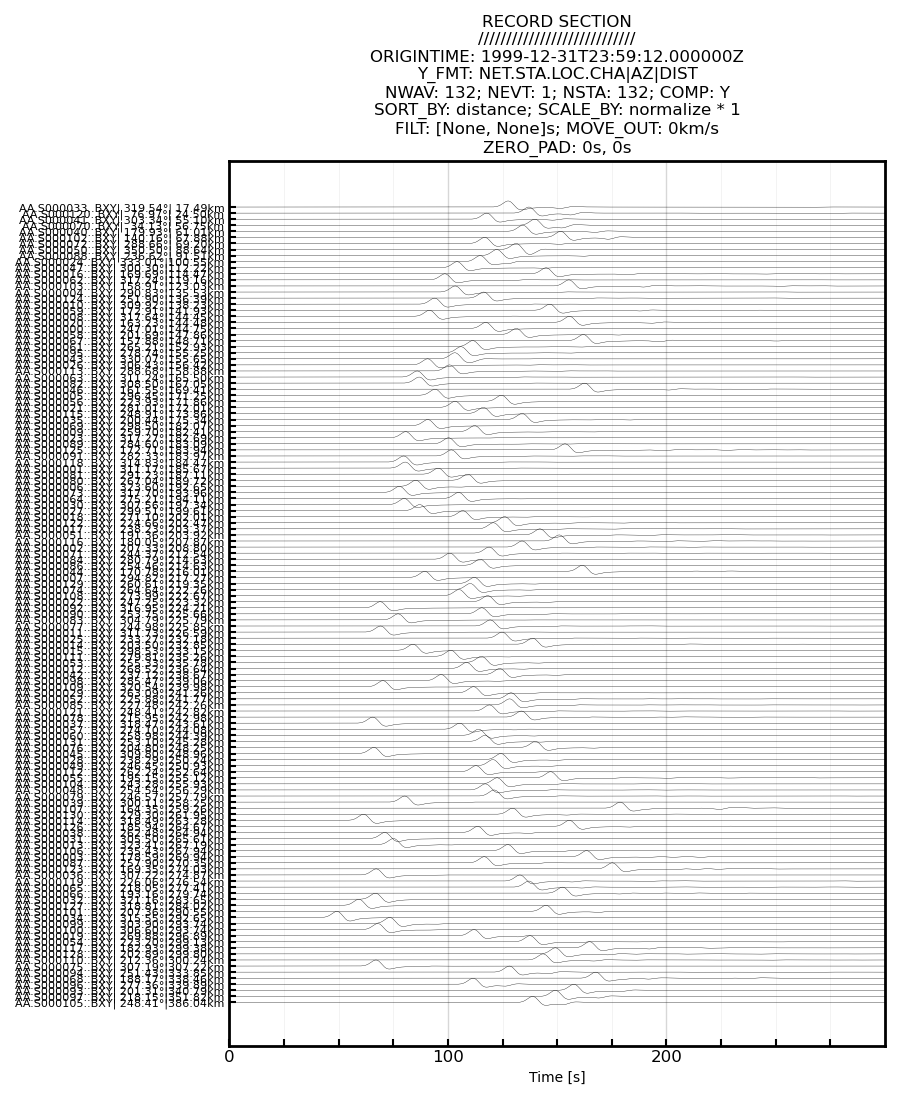

In [21]:
# We can use the record section tool in PySEP to plot our waveforms
! recsec --syn_path OUTPUT_FILES/ --cmtsolution DATA/SOURCE --stations DATA/STATIONS --components Y --cartesian -L INFO 
Image("record_section.png")

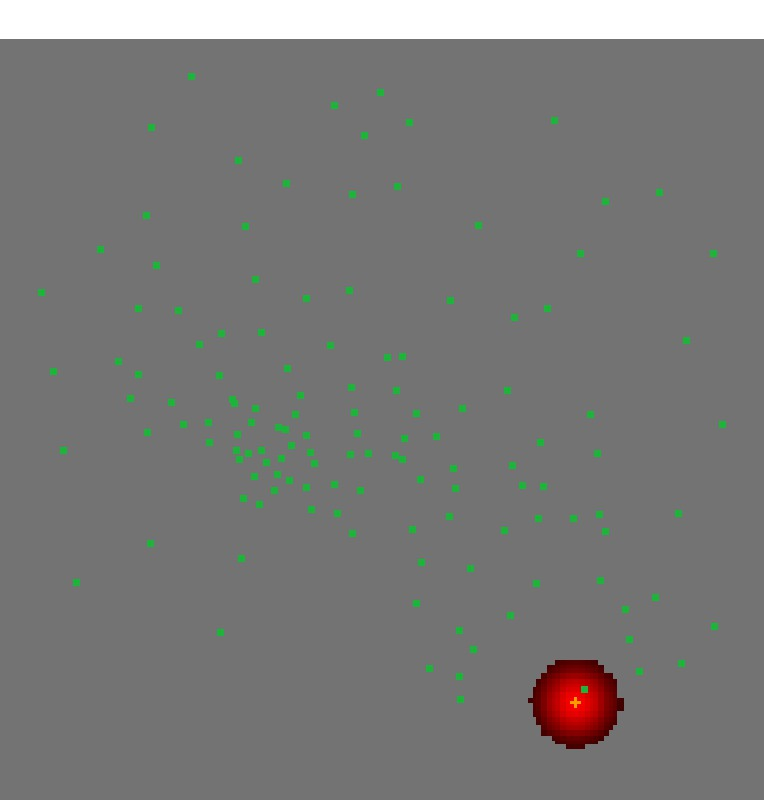

In [22]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000000800.jpg")

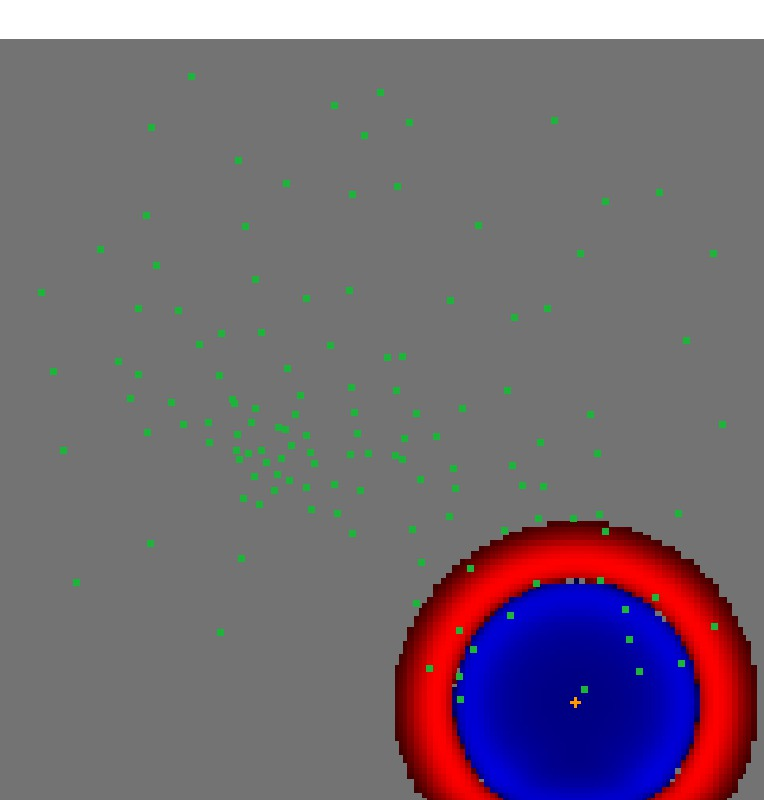

In [23]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000001200.jpg")

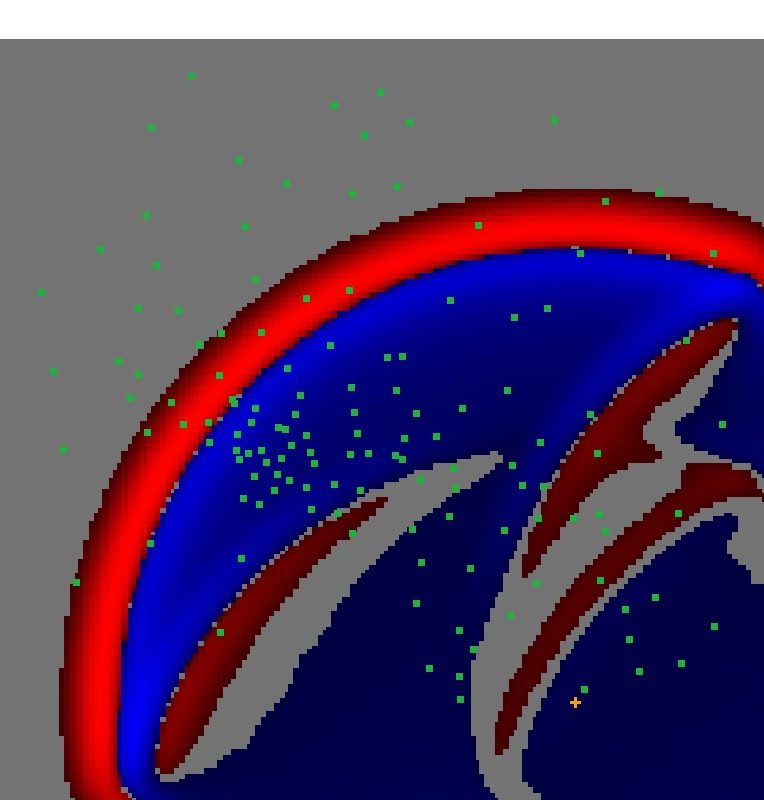

In [24]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000002200.jpg")

## 3) Choose Your Own Adventure

- Now that we have a working directory that we know produces synthetics, we can play around with our setup
- This is meant to emulate how a User would adjust SPECEFM to their own ressearch needs
- Some things that you are asked to try include:
    1) Change the parameters of the homogeneous halfspace model defined in the `Par_file` 
    2) Define a STATIONS file with a uniform grid of stations to record synthetics throughout the domain
    3) Choose a different source, or increase the energy released by the source (using the moment tensor)
    4) Re-run the mesher and solver to get new synthetics
    5) Analyze the new results in comparison to the old results

#### STEP 1: 
- Change the parameters in the homogeneous halfspace model
- You can use `seisflows sempar` or manually edit values using a Text Editor

#### STEP 2: 
- Define a STATIONS file with a uniform grid spacing of dx=5km and dz=5km
- Use Python/NumPy or simply write out a new text file with the text editor

#### STEP 3: 
- Edit the current source file to change it's location and moment release
- Have a look at the SOURCE file and make edits using a text editor
- What happens when you amplify the source? What happens when you change moment tensor components?
- How does changing the source time function affect the final waveform

In [ ]:
! cat DATA/SOURCE

#### STEP 4:
- Re-run the solver with your new experimental setup
- Remember, since we changed the model, we'll have to run the mesher and the solver again

#### STEP5:
- Analyze the output seismograms using Python, RecSec or SeisFlows
- How did your changes affect the resulting seismograms and wavefield snapshots?

## 4) Automating Forward Simulations with SeisFlows

- SeisFlows is an automated workflow tool which takes care of all the tasks required to run SPECFEM. 
- In essence, SeisFlows is a Python wrapper for SPECFEM, which includes modular components for interfacing with various compute systems. 
- SeisFlows also employs various preprocessing and optimization methods for seismic inversions (to be seen in Day 2 & 3). 
- We can automate forward simulations for multiple events in the Example we just ran. 
- SeisFlows Example \#3 runs a automated en-masse forward simulations.

In [28]:
# Make sure were running in a clean working directory
! mkdir /home/scoped/work/day_1/sfexample_3
%cd /home/scoped/work/day_1/sfexample_3

# The `example` command will setup and run our forward simulations
! seisflows examples run 3 -r /home/scoped/specfem2d/ --with_mpi --nproc 2

/home/scoped/work/day_1/sfexample_3

                                    @@@@@@@@@@                        
                               .@@@@.    .%&(  %@.          
                            @@@@   @@@@   &@@@@@@ ,%@       
                         @@@@   @@@,  /@@              @    
                        @@@   @@@@   @@@              @     
                      @@@@   @@@@   @@@                @  @ 
                      @@@   @@@@   ,@@@                @ @  
                     @@@@   @@@@    @@@@              @@ @ @
                     @@@@   @@@@@    @@@@@          @@@ @@ @
                     @@@@    @@@@@     @@@@@@@@@@@@@@  @@  @
                      @@@@    @@@@@@        @@@&     @@@  @ 
                      @@@@@     @@@@@@@@         %@@@@#  @@ 
                        @@@@#      @@@@@@@@@@@@@@@@@   @@   
                         &@@@@@          @@@@(       @@&    
                            @@@@@@@             /@@@@       
                                @@@@@@

#### Understanding SeisFlows outputs

- The example problem ran 10 simulations for 10 different sources (SOURCE_001 -> SOURCE_010)
- It used a homogeneous halfspace model, the same as shown above
- Each simulation output synthetic seismograms related to 25 station locations (Stations 1 -> 25)
- Each Solver directory is itself a small SPECFEM working directory
- SeisFlows stores its results in the `output/` directory
- In the example, we have told SeisFlows to export synthetic waveforms generated by the solver

In [31]:
# Each Solver directory is a SPECFEM working directory
! ls scratch/solver
! echo
! ls scratch/solver/001

001  002  003  004  005  006  007  008	009  010  mainsolver

bin  DATA  fwd_mesher.log  fwd_solver.log  OUTPUT_FILES  traces


Figure(707.107x707.107)


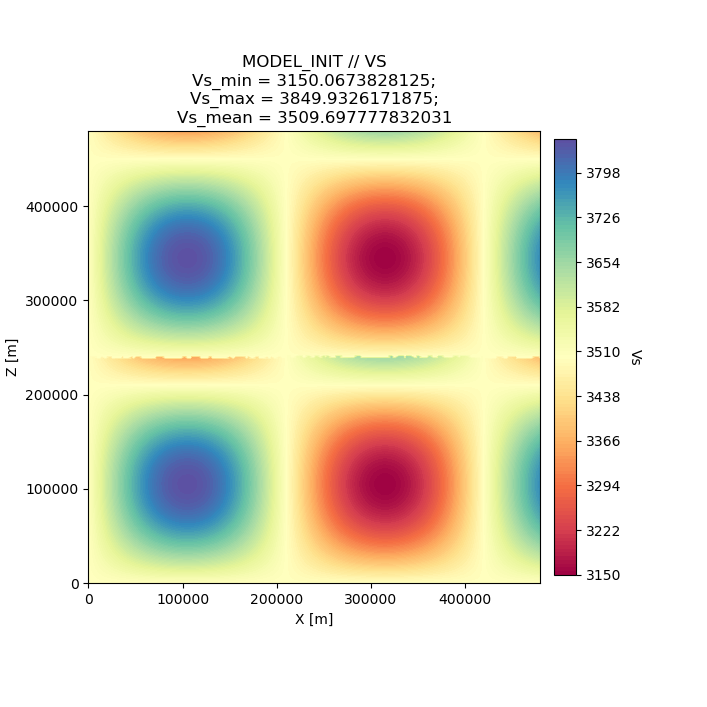

In [32]:
# We ran through a homogeneous halfspace model !!! WRONG, FIX ME !!!
! seisflows plot2d MODEL_INIT vs --savefig m_init_vs.png
Image("m_init_vs.png")

In [34]:
# Each solver exported its synthetics to the output/ directory
! ls output/solver
! echo
!ls output/solver/001/syn

001  002  003  004  005  006  007  008	009  010

AA.S000000.BXY.semd  AA.S000009.BXY.semd  AA.S000018.BXY.semd
AA.S000001.BXY.semd  AA.S000010.BXY.semd  AA.S000019.BXY.semd
AA.S000002.BXY.semd  AA.S000011.BXY.semd  AA.S000020.BXY.semd
AA.S000003.BXY.semd  AA.S000012.BXY.semd  AA.S000021.BXY.semd
AA.S000004.BXY.semd  AA.S000013.BXY.semd  AA.S000022.BXY.semd
AA.S000005.BXY.semd  AA.S000014.BXY.semd  AA.S000023.BXY.semd
AA.S000006.BXY.semd  AA.S000015.BXY.semd  AA.S000024.BXY.semd
AA.S000007.BXY.semd  AA.S000016.BXY.semd
AA.S000008.BXY.semd  AA.S000017.BXY.semd


[2022-09-17 00:44:19] - pysep - INFO: starting record section plotter
[2022-09-17 00:44:19] - pysep - INFO: Reading 25 synthetics from: output/solver/001/syn
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000000.BXY.semd
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000001.BXY.semd
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000002.BXY.semd
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000003.BXY.semd
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000004.BXY.semd
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000005.BXY.semd
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000006.BXY.semd
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000007.BXY.semd
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000008.BXY.semd
[2022-09-17 00:44:19] - pysep - DEBUG: output/solver/001/syn/AA.S000009.BXY.semd
[2022-09-17 00:44:19] - pysep - 

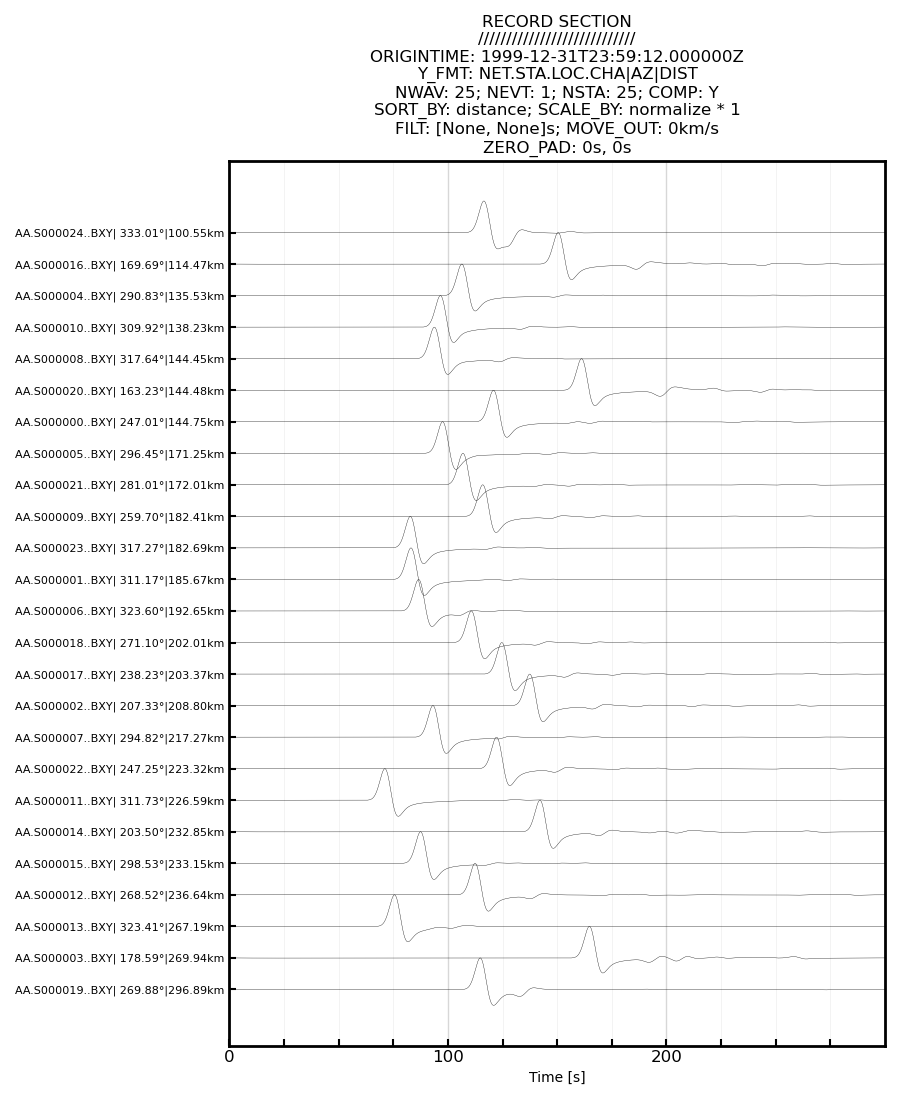

In [40]:
# We can plot synthetics for a single station using RecSec
! recsec --syn_path "output/solver/001/syn" --cmtsolution 'specfem2d_workdir/DATA/SOURCE_001' --stations 'specfem2d_workdir/DATA/STATIONS' --components Y --cartesian --save "s01_recsec.png"
Image("s01_recsec.png")